# Proposed Model Structured Neural network for the Closed Loop Dynamics



## Initialization

In [31]:
import os

print('Current working directory: ',os.getcwd())

Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


In [32]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.support.initializer import *
from nnodely.support.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely.support import earlystopping

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


## Datasets

In [33]:
from scipy.interpolate import interp1d

data_folder = os.path.join(os.getcwd(),'Dataset')

####### TRAINING DATA ########
data_folder_train = os.path.join(data_folder,'Complete Dynamics/training')
training_data=pd.read_csv(os.path.join(data_folder_train,'ftg_stanley_total_training.csv'))

####### VALIDATION DATA ########
data_folder_Validation = os.path.join(data_folder,'Complete Dynamics/validation')
Validation_data=pd.read_csv(os.path.join(data_folder_Validation,'ftg_stanley_total_validation.csv'))

####### TEST DATA ########

flag=0 # flag to chosse the test dataset
# flag=0 -> fg_single_mass_processed.csv
# flag=1 -> fg_double_mass_processed.csv
# flag=2 -> Frastagliate_tot.csv
# flag=3 -> Intermedie_tot.csv
# flag=4 -> Normal_1weight_v03.csv
# flag=5 -> Normal_2weights_v025.csv

data_folder_Test= os.path.join(data_folder,'Robusteness')

if flag==0:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'single_mass.csv'))
elif flag==1:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'double_mass.csv'))
elif flag==2:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_1.csv'))
elif flag==3:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_2.csv'))
elif flag==4:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_1weight.csv'))
elif flag==5:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_2weights.csv'))


## MS NN Structure

In [ ]:
# create the function computing the longitudinal acceleration with the model-based part
def acc_model_based(Ty,v,F_y,delta,
                    r1,mass,Kd,Cv,Cr,Iw1):  # learnable parameter
    # function inputs:
    # Ty,v --> wheel torques and vehicle speed

    # learnable parameters:
    # r1,mass,Kd,Cv,Cr,Iw1 --> wheel radius,vehicle mass, aero drag, linear drag and rolling resistance coefficients, wheel inertia
    
    # non-trainable parameters
    g_acc     = 9.81       # [m/s^2] gravity acceleration
    
    # function output: longitudinal acceleration, computed using the Newton's vehicle dynamics laws 
    return ((1.0/mass)*( 2*(Ty/r1) - Kd * v**2 - Cv * v - F_y*torch.sin(delta)) - Cr*g_acc)/(1.0 + (2.0/mass)*(2*(Iw1/r1**2.0)))

def acc_pos(T):
    mask_pos = torch.gt(T,0)
    return torch.mul(T,mask_pos)

def acc_neg(T):
    mask_pos = torch.gt(T,0)
    return torch.mul(T,~mask_pos)

def long_corr_lat_local(accy,accy_0,  # inputs
                    k1,k2          # learnable parameter 
                  ):
  return k1+ k2*(accy - accy_0)

def understeer_corr_local(input,vx,input_0, vx_0,ax,ax_0,  # inputs
                    k1,k2,k3,k4          # learnable parameter 
                  ):
  return vx*(k1+ k2*(input - input_0) + k3* (vx-vx_0)+k4*(ax-ax_0)) 

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
velocity         = Input('vel')          # [m/s] longitudinal velocity 
current          = Input('crt')          # [I] Motor current  
accx             = Input('acc')          # [m/s^2] Longitudinal acceleration 
accy             = Input('accy')         # [m/s^2] Lateral acceleration
delta            = Input('delta')        # [rad] steering angle
yaw_rate         = Input('yaw_rate')     # [rad/s] yaw rate

# -----------------------------------------------
ratio_rpm_v=4244.0 
# -----------------------------------------------
r1_guess = Parameter('r1',values=[[5e-3]])
mass_guess = Parameter('mass',values=[[3.5]])  # initial guess for the understeering gradient learnable parameter
Kd_guess = Parameter('Kd',values=[[1e-4]])     # initial guess for the understeering gradient learnable parameter
Cv_guess = Parameter('Cv',values=[[1e-4]])     # initial guess for the understeering gradient learnable parameter
Cr_guess = Parameter('Cr',values=[[1e-4]])     # initial guess for the understeering gradient learnable parameter
Iw1_guess = Parameter('Iw1',values=[[1e-4]])   # initial guess for the understeering gradient learnable parameter

# -----------------------------------------------
min_vx_train = min(training_data["Speed"].values/ratio_rpm_v)
max_vx_train = max(training_data["Speed"].values/ratio_rpm_v)
max_vx_val = max(Validation_data["Speed"].values/ratio_rpm_v)
min_delta_train = min(training_data["steering_angle"].values)
max_delta_train = max(training_data["steering_angle"].values)
min_ax_train = min(training_data["accx"].values*9.81)
max_ax_train = max(training_data["accx"].values*9.81)
min_ay_train = min(training_data["accy"].values*9.81)
min_ay_val = min(Validation_data["accy"].values*9.81)
max_ay_train = max(training_data["accy"].values*9.81)


## LONGITUDINAL DYNAMICS
# Dimensions of the layers
n  = 10
current_window = 15 # number of samples in the past for the motor current
# Build the MS-NN for the longitudinal dynamics
pos = ParamFun(acc_pos)(current.sw(current_window))
neg = ParamFun(acc_neg)(current.sw(current_window))
bias_value=0.0001
torque_layer_11 = Fir(output_dimension=n,b =True, b_init = init_negexp, b_init_params={'size_index':0, 'first_value':bias_value, 'lambda':3}, W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':3},dropout=0.05)(pos)
torque_layer_21 = Tanh(torque_layer_11)
torque_pos = Linear(torque_layer_21)

torque_layer_12 = Fir(output_dimension=n,b =True, b_init = init_negexp, b_init_params={'size_index':0, 'first_value':bias_value, 'lambda':3}, W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':3},dropout=0.05)(neg)
torque_layer_22 = Tanh(torque_layer_12)
torque_neg = Linear(torque_layer_22)

num_channels_accy_long = 4
num_channels_vx_long=2

chan_centers_accy_long = list(np.linspace(min_ay_train, max_ay_train, num=num_channels_accy_long))  # centers of the channels
chan_centers_vx_long = list(np.linspace(min_vx_train, max_vx_train, num=num_channels_vx_long))  # centers of the channels

# Define the centers of the channels for ay, ax, and az:
chan_centers_accy_list,chan_centers_speed_list = [], []
for idx_accy in range(num_channels_accy_long):
  chan_centers_accy_list.append(Constant('ay_center_' + str(idx_accy), values=chan_centers_accy_long[idx_accy]))

long_corr_lat = ParamFun(long_corr_lat_local)

def long_corr_lat_gen_long(idx_list):
  def long_corr_lat_map_long(accy):
    idx_accy=idx_list[0]
    k1 = Parameter('k1_'+ str(idx_accy),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k2 = Parameter('k2_'+ str(idx_accy),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    accy_0 = chan_centers_accy_list[idx_accy]
    return long_corr_lat(accy,accy_0,k1,k2)
  return long_corr_lat_map_long

fuzz_long_corr_lat_transient_long = Fuzzify(centers=chan_centers_vx_long, functions='Triangular')(velocity.sw(current_window))
fuzz_long_corr_lat_ss_2_long = Fuzzify(centers=chan_centers_accy_long, functions='Triangular')(accy.sw(current_window))

local_model_ss_long = LocalModel(input_function=long_corr_lat_gen_long,pass_indexes=True)((accy.sw(current_window)), (fuzz_long_corr_lat_ss_2_long))

Fy = LocalModel(output_function=lambda: Fir(W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':5, 'monotonicity':'increasing'}))(local_model_ss_long, fuzz_long_corr_lat_transient_long)


## LATERAL DYNAMICS
num_samples_past    = 20 # number of samples in the past for the steering wheel angle prediction

# Number of channels for forward speed
num_channels_vx = 2
num_channels_delta = 5
num_channels_ax = 2

chan_centers_vx = list(np.linspace(min_vx_train, max_vx_train, num=num_channels_vx))  # centers of the channels
chan_centers_delta = list(np.linspace(min_delta_train, max_delta_train, num=num_channels_delta))  # centers of the channels
chan_centers_ax = list(np.linspace(min_ax_train, max_ax_train, num=num_channels_ax))  # centers of the channels

# Define the centers of the channels for ay, ax, and az:
chan_centers_steer_list, chan_centers_speed_list,chan_centers_ax_list = [], [], []
for idx_ay in range(num_channels_delta):
  chan_centers_steer_list.append(Constant('steer_center_' + str(idx_ay), values=chan_centers_delta[idx_ay]))
for idx_vx in range(num_channels_vx):
  chan_centers_speed_list.append(Constant('vx_center_' + str(idx_vx), values=chan_centers_vx[idx_vx]))
for idx_ax in range(num_channels_ax):
  chan_centers_ax_list.append(Constant('ax_center_' + str(idx_ax), values=chan_centers_ax[idx_ax]))

understeer_corr = ParamFun(understeer_corr_local)

def understeer_corr_gen(idx_list):
  def understeer_corr_map(input,vx,ax):
    idx_ax=idx_list[2]
    idx_steer=idx_list[1]
    idx_speed=idx_list[0]
    k1 = Parameter('lat_k1_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k2 = Parameter('lat_k2_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k3 = Parameter('lat_k3_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k4 = Parameter('lat_k4_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter

    input_0 = chan_centers_steer_list[idx_steer]
    vx_0 = chan_centers_speed_list[idx_speed]
    ax_0 = chan_centers_ax_list[idx_ax]
    return understeer_corr(input,vx,input_0,vx_0,ax,ax_0,k1,k2,k3,k4)
  return understeer_corr_map


[check_names] The name 'vel' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'crt' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'acc' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'accy' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'delta' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'yaw_rate' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'r1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'mass' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'Kd' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'Cv' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'Cr' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'Iw1' is already in defined as NeuObj but it is 

In [35]:
fuzz_lateral_transient = Fuzzify(centers=chan_centers_vx, functions='Triangular')(velocity.sw(num_samples_past))
fuzz_ax_transient = Fuzzify(centers=chan_centers_ax, functions='Triangular')(accx.sw(num_samples_past))

fuzz_lateral_ss_2 = Fuzzify(centers=chan_centers_delta, functions='Triangular')(delta.sw(num_samples_past))
fuzz_lateral_ss_1 = Fuzzify(centers=chan_centers_vx, functions='Triangular')(velocity.sw(num_samples_past))
fuzz_lateral_ss_3 = Fuzzify(centers=chan_centers_ax, functions='Triangular')(accx.sw(num_samples_past))

# Parametric function to model the understeering gradient correction
local_model_ss = LocalModel(input_function=understeer_corr_gen,pass_indexes=True)((delta.sw(num_samples_past), velocity.sw(num_samples_past),accx.sw(num_samples_past)), (fuzz_lateral_ss_1, fuzz_lateral_ss_2,fuzz_lateral_ss_3))

local_model_transient = LocalModel(output_function=lambda: Fir(W_init = init_negexp, W_init_params={'size_index':0, 'first_value':0.0001, 'lambda':5, 'monotonicity':'increasing'}))(local_model_ss, (fuzz_lateral_transient,fuzz_ax_transient))

# Model output: trajectory curvature at the current time step
yaw_rate_out = Output('yaw_rate_', local_model_transient)  # output of the model
accy_computed = Output('accy_computed', local_model_transient*velocity.last())  # output of the model

# Build a parametric function for the model-based part of the MS-NN
model_based_out = ParamFun(acc_model_based, 
                           parameters_and_constants=[r1_guess,mass_guess,Kd_guess,Cv_guess,Cr_guess,Iw1_guess]
                           )(torque_neg+torque_pos,velocity.last(),Fy,delta.last())
# Create neural network output
acc_out = Output('acceleration', model_based_out)


[check_names] The name 'lat_k1_0_0_0' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k2_0_0_0' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k3_0_0_0' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k4_0_0_0' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k1_0_0_1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k2_0_0_1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k3_0_0_1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k4_0_0_1' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k1_0_0_2' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k2_0_0_2' is already in defined as NeuObj but it is overwritten.
[check_names] The name 'lat_k3_0_0_2' is already in defined as NeuObj 

### nnodely definitions

In [36]:
# Create a nnodely model
path_folder   = os.path.join(os.getcwd(),'trained_models','Combined_dynamics')    # folder to save the model without auto-regression
dynamics   = nnodely(visualizer='Standard',seed=12,workspace=path_folder,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
dynamics.addModel('yaw_rate',[yaw_rate_out,accy_computed])
dynamics.addMinimize('yaw_rate_error', 
                                    yaw_rate.next(),  # next means the first value in the "future"
                                    yaw_rate_out, 
                                    loss_function='rmse')

dynamics.addModel('acc',[acc_out])
dynamics.addMinimize('acc_error', 
                                    accx.next(),  # next means the first value in the "future"
                                    acc_out,  # output of the model
                                    loss_function='rmse')

In [38]:
dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.2467806041240692]},
               'steer_center_4': {'dim': 1, 'values': [0.4189000129699707]},
           

## Training and validation datasets

In [39]:
# -----------------------------------------------
from scipy.constants import g
speed_ms_train=(training_data["Speed"].values)/ratio_rpm_v
yaw_rate_train=np.deg2rad(training_data["yaw_rate"].values)
torque_train=training_data["current"].values
acc_train=training_data["accx"].values*g
delta_train=training_data["steering_angle"].values
accy_train=training_data["accy"].values*g
dataset_training = {'vel': speed_ms_train, 'crt': torque_train, 'acc' : acc_train, 'delta' : delta_train , 'accy' : accy_train, 'yaw_rate' : yaw_rate_train}

speed_ms_validation=(Validation_data["Speed"].values)/ratio_rpm_v
yaw_rate_validation=np.deg2rad(Validation_data["yaw_rate"].values)
torque_validation=Validation_data["current"].values
acc_validation=Validation_data["accx"].values*g
delta_validation=Validation_data["steering_angle"].values
accy_validation=Validation_data["accy"].values*g
dataset_validation = {'vel': speed_ms_validation, 'crt': torque_validation, 'acc' : acc_validation, 'delta' : delta_validation, 'accy' : accy_validation, 'yaw_rate' : yaw_rate_validation}

yaw_rate_test=np.deg2rad(Test_data["yaw_rate"].values)
speed_ms_test=(Test_data["Speed"].values)/ratio_rpm_v
torque_test=Test_data["current"].values
acc_test=Test_data["accx"].values*g
accy_test=Test_data["accy"].values*g
delta_test=Test_data["steering_angle"].values
dataset_test = {'vel': speed_ms_test, 'crt': torque_test, 'acc' : acc_test, 'delta' : delta_test , 'accy' : accy_test, 'yaw_rate' : yaw_rate_test}

# Pass the training and the validation datasets to the nnodely structure

dynamics.loadData(name='training_set', source=dataset_training)
dynamics.loadData(name='validation_set', source=dataset_validation)
dynamics.loadData(name='Test_set', source=dataset_test)

============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      2516
Shape of delta:               (2516, 15, 1)
Shape of vel:                 (2516, 15, 1)
Shape of accy:                (2516, 15, 1)
Shape of crt:                 (2516, 15, 1)
Shape of acc:                 (2516, 16, 1)
Shape of yaw_rate:            (2516, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      1182
Shape of delta:               (1182, 15, 1)
Shape of vel:                 (1182, 15, 1)
Shape of accy:                (1182, 15, 1)
Shape of crt:                 (1182, 15, 1)
Shape of acc:                 (1182, 16, 1)
Shape of yaw_rate:            (1182, 1, 1)
============================ nnodely Model Dataset =============================
Dataset N

## Training

In [40]:
dynamics.exportPythonModel()
dynamics.exportONNX()

=============================== Save JSON Model ================================
Model saved in:               c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics\net.json
========================== Export Python Torch Model ===========================
Model exported in:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics\net.py
The inputs order for the export is not specified, the order will set equal to {'acc', 'yaw_rate', 'accy', 'vel', 'delta', 'crt'}.
The outputs order for the export is not specified, the order will set equal to {'acceleration', 'accy_computed', 'yaw_rate_'}
========================== Export Python Torch Model ===========================
Model exported in:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics\onnx\net.py
======================== Export Python Onnx Torch Model ========================
Model exported in:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\train

In [41]:
dynamics.importPythonModel()

=============================== Load JSON Model ================================
Model loaded from:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics\net.json
================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'val

### Training Lateral Model

In [ ]:
num_epochs = 1500
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 300
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate,
                 'models': 'yaw_rate',
                 }

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = dynamics.trainAndAnalyze(train_dataset='training_set', validation_dataset='validation_set', test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'yaw_rate_error'}
                                                                                    
                                                                                    )  
else:
  # Load the trained model
  dynamics.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['yaw_rate']
num of epochs:                7000
update per epochs:            25
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'yaw_rate_error', 'patience': 300}
train dataset:                training_set
	- batch size:                100
	- num of samples:            2516
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            1182
minimizers:                   {'acc_error': {'A': 'SamplePart2435',
                                             'B': 'ParamFun2431',
                                             'loss': 'rmse'},
                               'yaw_rate_error': {'A': 'SamplePart2433',
                                                  'B': 'Add2422',
                                                 

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.2467806041240692]},
               'steer_center_4': {'dim': 1, 'values': [0.4189000129699707]},
           

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

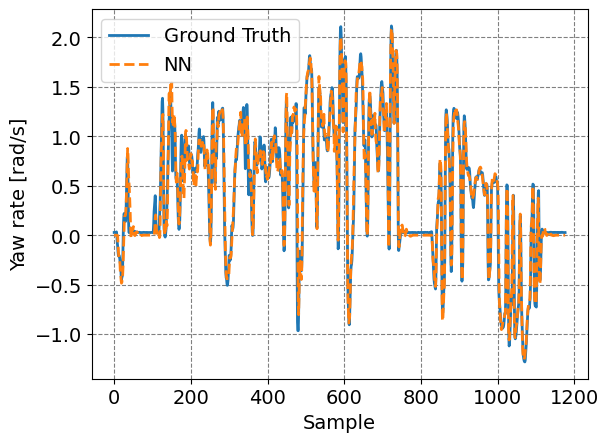

RMSE on the test set:  [0.07311309]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

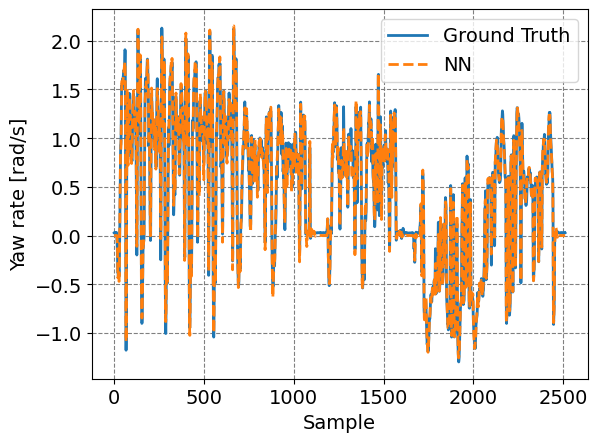

In [43]:
# Print the trained NN parameters
dynamics.neuralizeModel()
# Test on a new dataset
num_samples_use  = np.size(yaw_rate_validation)-num_samples_past-5
samples_test_set = dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['yaw_rate'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_test_set_extract
            ),label='Ground Truth',linewidth=2)
  plt.plot((out_nn_test_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()


# Test on a new dataset
num_samples_use  = np.size(yaw_rate_train)-num_samples_past-5
samples_test_set = dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['yaw_rate'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_test_set_extract
            ),label='Ground Truth',linewidth=2)
  plt.plot((out_nn_test_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()

### Training Longitudinal Model

In [44]:
num_epochs = 3000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 500
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate,
                 'models': 'acc'                                                                               
                 }

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = dynamics.trainAndAnalyze(train_dataset='training_set', validation_dataset='validation_set', test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'acc_error'}                                                                                    
                                                                                    )  
else:
  # Load the trained model
  dynamics.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['acc']
num of epochs:                3000
update per epochs:            25
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'acc_error', 'patience': 500}
train dataset:                training_set
	- batch size:                100
	- num of samples:            2516
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            1182
minimizers:                   {'acc_error': {'A': 'SamplePart2435',
                                             'B': 'ParamFun2431',
                                             'loss': 'rmse'},
                               'yaw_rate_error': {'A': 'SamplePart2433',
                                                  'B': 'Add2422',
                                                  'loss': '

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.2467806041240692]},
               'steer_center_4': {'dim': 1, 'values': [0.4189000129699707]},
           

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

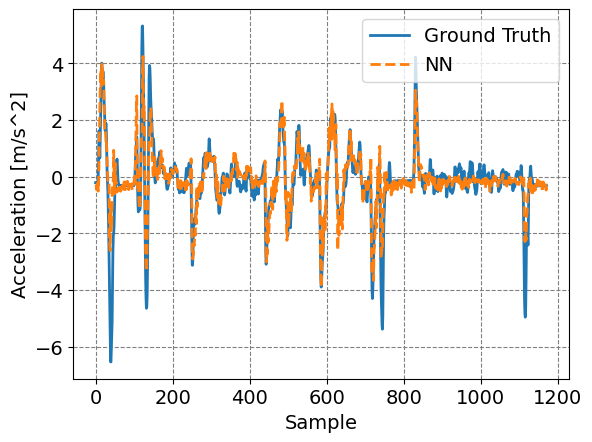

RMSE on the test set:  [0.4456919]  [m/s^2]


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

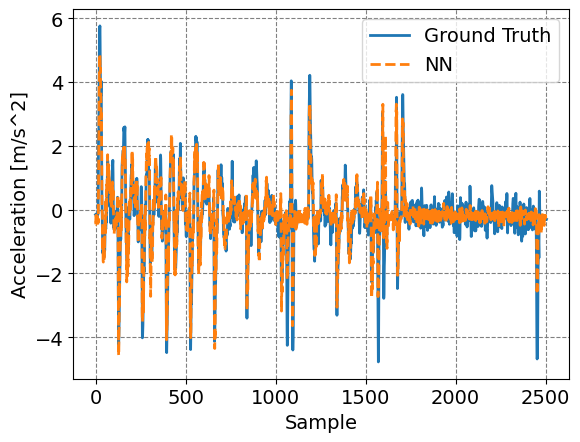

=============================== Save JSON Model ================================
Model saved in:               c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Combined_dynamics\net.json


In [45]:
# Print the trained NN parameters
dynamics.neuralizeModel()

# Test on the validation dataset
num_samples_use  = np.size(acc_validation)-25
samples_test_set = dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['acceleration'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['acc'][i][15]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, '[m/s^2] ')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()


# Test on the training dataset
num_samples_use  = np.size(acc_train)-25
samples_test_set = dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['acceleration'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['acc'][i][15]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, ' [m/s^2]')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()

if flag_train_now:
  # Save the trained model
  dynamics.saveModel()

### Training Closed Loop

In [46]:
dynamics.addConnect(accy_computed,accy)
dynamics.addClosedLoop(acc_out,accy)
dynamics.neuralizeModel()

num_epochs = 1000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 200
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate,
                 'connect':{'accy':'accy_computed'},
                 'closed_loop':{'acc':'acceleration'},                                                                         
                 }

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = dynamics.trainAndAnalyze(train_dataset='training_set', validation_dataset='validation_set', test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'yaw_rate_error'}
                                                                                    
                                                                                    )  
else:
  # Load the trained model
  dynamics.loadModel() 

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.2467806041240692]},
               'steer_center_4': {'dim': 1, 'values': [0.4189000129699707]},
           

In [47]:
# Print the trained NN parameters
dynamics.neuralizeModel()

if flag_train_now:
  # Save the trained model
  dynamics.saveModel()

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-4.772998809814453]},
               'ax_center_1': {'dim': 1, 'values': [0.49301645159721375]},
               'ax_center_2': {'dim': 1, 'values': [5.759031772613525]},
               'ay_center_0': {'dim': 1, 'values': [-3.747269868850708]},
               'ay_center_1': {'dim': 1, 'values': [-0.28388628363609314]},
               'ay_center_2': {'dim': 1, 'values': [3.179497241973877]},
               'ay_center_3': {'dim': 1, 'values': [6.642880916595459]},
               'steer_center_0': {'dim': 1, 'values': [-0.26957762241363525]},
               'steer_center_1': {'dim': 1, 'values': [-0.09745820611715317]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.2467806041240692]},
               'steer_center_4': {'dim': 1, 'values': [0.4189000129699707]},
           

## Results

RMSE on the test set:  [0.00840213] [m/s^2] 
RMSE on the test set:  [0.0013057] [m/s^2] 


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

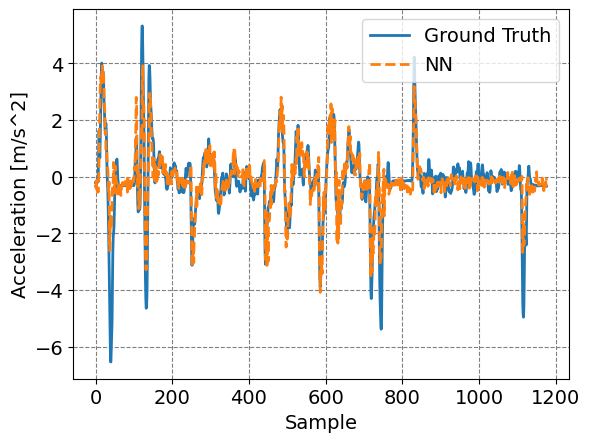

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

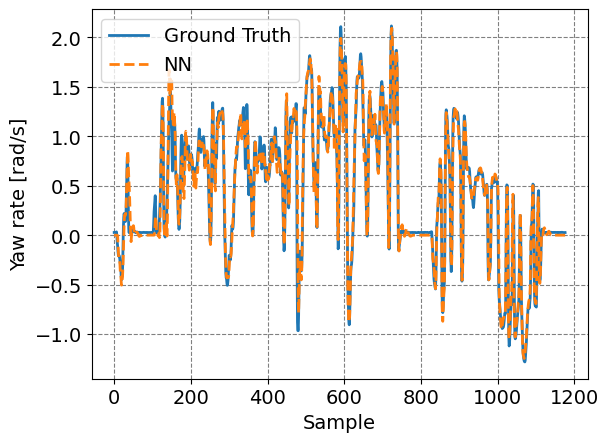

In [48]:
# Test on the validation dataset
num_samples_use  = np.size(acc_validation)-num_samples_past-5
samples_test_set = dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract_acc = np.asarray(out_nn_test_set['acceleration'])
out_nn_test_set_extract_yaw_rate = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract_acc = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract_acc)):
  samples_test_set_extract_acc[i] = samples_test_set['acc'][i][15]

samples_test_set_extract_yaw_rate = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  samples_test_set_extract_yaw_rate[i] = samples_test_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc_acc = 0
for i in range(0,len(samples_test_set_extract_acc)):
  mse_calc_acc = mse_calc_acc + (samples_test_set_extract_acc[i] - out_nn_test_set_extract_acc[i])**2 
  mse_calc_acc = np.sqrt(mse_calc_acc/len(samples_test_set_extract_acc))
print('RMSE on the test set: ', mse_calc_acc, '[m/s^2] ')

mse_calc_yaw_rate = 0
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  mse_calc_yaw_rate = mse_calc_yaw_rate + (samples_test_set_extract_yaw_rate[i] - out_nn_test_set_extract_yaw_rate[i])**2 
  mse_calc_yaw_rate = np.sqrt(mse_calc_yaw_rate/len(samples_test_set_extract_yaw_rate))
print('RMSE on the test set: ', mse_calc_yaw_rate, '[m/s^2] ')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract_acc,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_acc,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot(samples_test_set_extract_yaw_rate,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_yaw_rate,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()


RMSE on the test set:  [0.00479987] [m/s^2] 
RMSE on the test set:  [0.00079117] [m/s^2] 


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

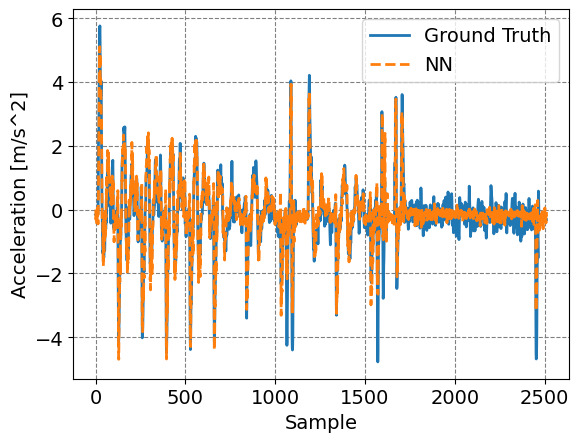

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

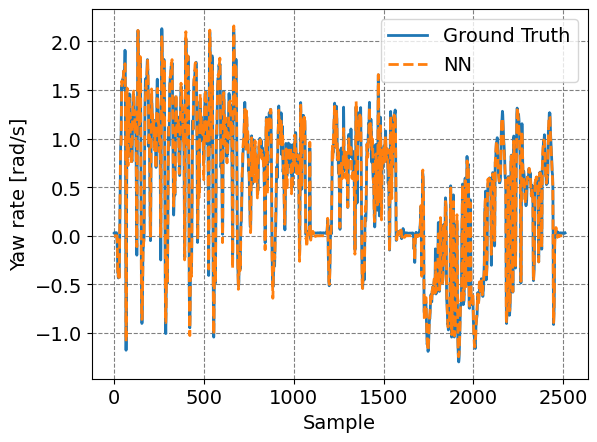

In [49]:
# Test on the validation dataset
num_samples_use  = np.size(acc_train)-num_samples_past-5
samples_test_set = dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract_acc = np.asarray(out_nn_test_set['acceleration'])
out_nn_test_set_extract_yaw_rate = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract_acc = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract_acc)):
  samples_test_set_extract_acc[i] = samples_test_set['acc'][i][15]

samples_test_set_extract_yaw_rate = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  samples_test_set_extract_yaw_rate[i] = samples_test_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc_acc = 0
for i in range(0,len(samples_test_set_extract_acc)):
  mse_calc_acc = mse_calc_acc + (samples_test_set_extract_acc[i] - out_nn_test_set_extract_acc[i])**2 
  mse_calc_acc = np.sqrt(mse_calc_acc/len(samples_test_set_extract_acc))
print('RMSE on the test set: ', mse_calc_acc, '[m/s^2] ')

mse_calc_yaw_rate = 0
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  mse_calc_yaw_rate = mse_calc_yaw_rate + (samples_test_set_extract_yaw_rate[i] - out_nn_test_set_extract_yaw_rate[i])**2 
  mse_calc_yaw_rate = np.sqrt(mse_calc_yaw_rate/len(samples_test_set_extract_yaw_rate))
print('RMSE on the test set: ', mse_calc_yaw_rate, '[m/s^2] ')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract_acc,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_acc,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot(samples_test_set_extract_yaw_rate,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_yaw_rate,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()
  

RMSE on the test set:  [0.00657656] [m/s^2] 
RMSE on the test set:  [0.00379104] [m/s^2] 


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

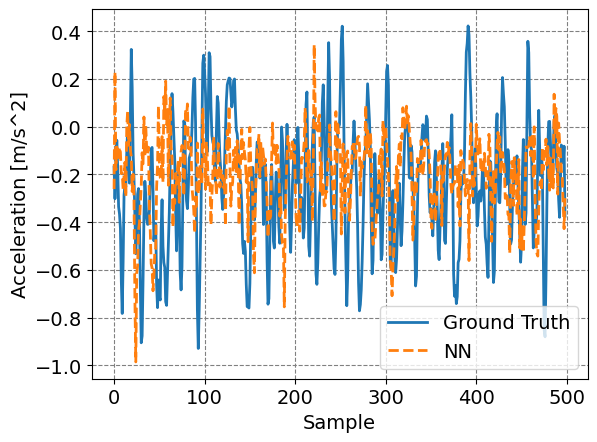

c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

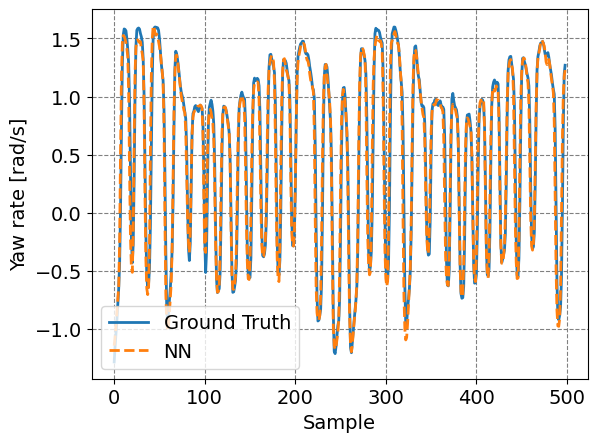

In [50]:
# Test on the test dataset

num_samples_use  = np.size(acc_test)-num_samples_past-5
samples_test_set = dynamics.getSamples('Test_set', index=0, window=num_samples_use) 
out_nn_test_set  = dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract_acc = np.asarray(out_nn_test_set['acceleration'])
out_nn_test_set_extract_yaw_rate = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract_acc = np.zeros((len(samples_test_set['acc']),1))
for i in range(0,len(samples_test_set_extract_acc)):
  samples_test_set_extract_acc[i] = samples_test_set['acc'][i][15]

samples_test_set_extract_yaw_rate = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  samples_test_set_extract_yaw_rate[i] = samples_test_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc_acc = 0
for i in range(0,len(samples_test_set_extract_acc)):
  mse_calc_acc = mse_calc_acc + (samples_test_set_extract_acc[i] - out_nn_test_set_extract_acc[i])**2 
  mse_calc_acc = np.sqrt(mse_calc_acc/len(samples_test_set_extract_acc))
print('RMSE on the test set: ', mse_calc_acc, '[m/s^2] ')

mse_calc_yaw_rate = 0
for i in range(0,len(samples_test_set_extract_yaw_rate)):
  mse_calc_yaw_rate = mse_calc_yaw_rate + (samples_test_set_extract_yaw_rate[i] - out_nn_test_set_extract_yaw_rate[i])**2 
  mse_calc_yaw_rate = np.sqrt(mse_calc_yaw_rate/len(samples_test_set_extract_yaw_rate))
print('RMSE on the test set: ', mse_calc_yaw_rate, '[m/s^2] ')


flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(samples_test_set_extract_acc,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_acc,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Acceleration [m/s^2]')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot(samples_test_set_extract_yaw_rate,label='Ground Truth',linewidth=2)
  plt.plot(out_nn_test_set_extract_yaw_rate,label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()
  